In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, f1_score, confusion_matrix
import lightgbm as lgb

import seaborn as sns
import matplotlib.pyplot as plt
import warnings

In [2]:
# Google Colab環境ではGoogle Driveをマウントしてアクセスできるようにします。
import sys

if 'google.colab' in sys.modules:
    # Google Drive をマウントします
    from google.colab import drive
    mount_dir = "/content/drive"
    drive.mount(mount_dir)

Mounted at /content/drive


In [3]:
class GroupFeatureExtractor:  # 参考: https://signate.jp/competitions/449/discussions/lgbm-baseline-lb06240
    EX_TRANS_METHODS = ["deviation", "zscore"]
    
    def __init__(self, group_key, group_values, agg_methods):
        self.group_key = group_key
        self.group_values = group_values

        self.ex_trans_methods = [m for m in agg_methods if m in self.EX_TRANS_METHODS]
        self.agg_methods = [m for m in agg_methods if m not in self.ex_trans_methods]
        self.df_agg = None

    def fit(self, df_train, y=None):
        if not self.agg_methods:
            return
        dfs = []
        for agg_method in self.agg_methods:
            if callable(agg_method):
                agg_method_name = agg_method.__name__
            else:
                agg_method_name = agg_method
            df_agg = (df_train[[self.group_key] + self.group_values].groupby(self.group_key).agg(agg_method))
            df_agg.columns = self._get_column_names(agg_method_name)
            dfs.append(df_agg)
        self.df_agg = pd.concat(dfs, axis=1).reset_index()


    def transform(self, df_eval):
        key = self.group_key
        if self.agg_methods:
            df_features = pd.merge(df_eval[[self.group_key]], self.df_agg, on=self.group_key, how="left")
        else:
            df_features = df_eval[[self.group_key]].copy()
        if self.ex_trans_methods:
            if "deviation" in self.ex_trans_methods:
                df_features[self._get_agg_column_names("deviation")] = df_eval[self.group_values] - df_eval[[key]+self.group_values].groupby(key).transform("mean")
            if "zscore" in self.ex_trans_methods:
                df_features[self._get_column_names("zscore")] = (df_eval[self.group_values] - df_eval[[key]+self.group_values].groupby(key).transform("mean")) \
                                                                / (df_eval[[key]+self.group_values].groupby(key).transform("std") + 1e-8)
        df_features.drop(self.group_key, axis=1, inplace=True)
        return df_features

    def _get_column_names(self, method):
        return [f"agg_{method}_{col}_grpby_{self.group_key}" for col in self.group_values]

    def fit_transform(self, df_train, y=None):
        self.fit(df_train, y=y)
        return self.transform(df_train)

def merge_train_test(df_train, df_test):
    if "genre" not in df_test.columns.tolist():
        df_test["genre"] = -100
    res = pd.concat([df_train, df_test])
    res.reset_index(inplace=True, drop=True)
    return res

def split_train_test(df):
    df_train = df[df["genre"] != -100]
    df_test = df[df["genre"] == -100]
    df_train.reset_index(inplace=True, drop=True)
    df_test.reset_index(inplace=True, drop=True)
    return df_train, df_test


N_SPLITS = 15
SEED_SKF = 42
np.random.seed(42)
# cross validation
def training_knn_model(df_train, target, df_test, features, n_neighbors=6, N_SPLITS=N_SPLITS):
  """
  Trainデータ
  Trainデータの予測値
  Testデータ
  分割する個数
  """
  skf = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=SEED_SKF)
  oof = np.zeros((len(df_train), N_CLASSES))
  predictions = np.zeros((len(df_test), N_CLASSES))
  df_feature_importance = pd.DataFrame()

  # Null値の穴埋めを考える
  df_train = df_train[features].fillna(df_train[features].median()) * feature_weights
  df_test = df_test[features].fillna(df_train[features].median()) * feature_weights

  for fold_, (indexes_trn, indexes_val) in enumerate(skf.split(df_train.values, target.values)):
      print(f"------------------------------ fold {fold_} ------------------------------")
      
      df_trn = df_train.loc[indexes_trn].reset_index(drop=True)
      df_val = df_train.loc[indexes_val].reset_index(drop=True)
      target_trn = target.loc[indexes_trn].reset_index(drop=True)
      target_val = target.loc[indexes_val].reset_index(drop=True)
      
      model = KNeighborsClassifier(n_neighbors + 1, weights="distance", algorithm="ball_tree")    
      model.fit(df_trn, target_trn)
      distances, indexes = model.kneighbors(df_trn)
      prediction = model.predict(df_val)
      score = f1_score(target_val, prediction, average="macro")
      print(f"f1_score={score}\n")

      oof[indexes_val] = model.predict_proba(df_val)
      predictions += model.predict_proba(df_test) / N_SPLITS

  df_test["prediction"] = predictions.argmax(1)
  score = f1_score(target, oof.argmax(1), average="macro")
  print("CV score")
  print(f"  f1: {score:8.5f}")
  print()
  return oof, predictions

In [4]:
warnings.simplefilter('ignore', pd.core.common.SettingWithCopyWarning)
warnings.simplefilter('ignore', UserWarning)

N_CLASSES = 11
foldar_path = "/MyDrive/competitions/学生コンペ春/input/"

INPUT = mount_dir + foldar_path

train = pd.read_csv(INPUT + "train.csv")
test = pd.read_csv(INPUT + "test.csv")
df_sample_sub = pd.read_csv(INPUT + "sample_submit.csv", header=None)
df_sample_sub.columns = ["index", "genre"]
df_genre_labels = pd.read_csv(INPUT + "genre_labels.csv")

## 前処理

In [5]:
# feature engineering
df_train = train.copy()
df_test = test.copy()
df = merge_train_test(df_train, df_test)

df["genre_name"] = df["genre"].map(dict(df_genre_labels[["labels", "genre"]].values))

df["tempo"] = df["tempo"].map(lambda x: sum(map(int, x.split("-"))) / 2)

df = pd.concat([df, pd.get_dummies(df["region"]).rename(columns={"unknown": "region_unknown"})], axis=1)

df["num_nans"] = 0
for col in [
    "acousticness",
    "positiveness",
    "danceability",
    "energy",
    "liveness",
    "speechiness",
    "instrumentalness",
]:
    q01 = df[col].quantile(0.01)
    q99 = df[col].quantile(0.99)
    df[col] = df[col].clip(q01, q99)
    df["num_nans"] += df[col].isna()

# feature scaling
df["log_tempo"] = np.log(df["tempo"])

gfe = GroupFeatureExtractor(
    "region", 
    ['duration_ms', 'acousticness', 'popularity'],
    ["zscore"]
)
df = pd.concat([df, gfe.fit_transform(df)], axis=1)
group_region_column = list(gfe.fit_transform(df).columns)
group_standard_column = []
for col in group_region_column:
  group_standard_column.append("standardscaled_"+col)


df['danceability_speechiness'] = df["danceability"] * df["speechiness"]


for col in [
    'popularity', 'duration_ms', 'acousticness',
    'positiveness', 'danceability', 'loudness', 'energy', 'liveness',
    'speechiness', 'instrumentalness', 'log_tempo', 'num_nans', 'danceability_speechiness'
] + group_region_column:
    df["standardscaled_" + col] = StandardScaler().fit_transform(df[[col]])[:, 0]


df_train, df_test = split_train_test(df)
target = df_train["genre"]

## KNNの特徴量設定

In [6]:
# feature weights
features = [
   'region_A', 'region_B', 'region_C', 'region_D', 'region_E', 'region_F',
   'region_G', 'region_H', 'region_I', 'region_J', 'region_K', 'region_L',
   'region_M', 'region_N', 'region_O', 'region_P', 'region_Q', 'region_R',
   'region_S', 'region_T', 'region_unknown',
   'standardscaled_popularity', 'standardscaled_duration_ms',
   'standardscaled_acousticness', 'standardscaled_positiveness',
   'standardscaled_danceability', 'standardscaled_loudness',
   'standardscaled_energy', 'standardscaled_liveness',
   'standardscaled_speechiness', 'standardscaled_instrumentalness',
    'standardscaled_agg_zscore_acousticness_grpby_region', 
   'standardscaled_agg_zscore_duration_ms_grpby_region',
 'standardscaled_danceability_speechiness'
]


dict_feature_weights = {}

for col in [
    'region_A', 'region_B', 'region_C', 'region_D', 'region_E', 'region_F',
    'region_G', 'region_H', 'region_I', 'region_J', 'region_K', 'region_L',
    'region_M', 'region_N', 'region_O', 'region_P', 'region_Q', 'region_R',
    'region_S', 'region_T', 'region_unknown'
]:
    dict_feature_weights[col] = 100.0

for col in [
    'standardscaled_duration_ms',
    'standardscaled_acousticness', 'standardscaled_positiveness',
    'standardscaled_danceability', 'standardscaled_loudness',
    'standardscaled_energy', 'standardscaled_liveness',
    'standardscaled_speechiness', 'standardscaled_instrumentalness'
] :
    dict_feature_weights[col] = 1.0

for col in ['standardscaled_agg_zscore_acousticness_grpby_region', 'standardscaled_agg_zscore_duration_ms_grpby_region']:
    dict_feature_weights[col] = 1.0


for col in ['standardscaled_danceability_speechiness']:
    dict_feature_weights[col] = 1.0

dict_feature_weights["standardscaled_popularity"] = 8.0

feature_weights = np.array([dict_feature_weights[col] for col in features])

## 学習

In [7]:
n_neighbors = 5
N_SPLITS = 15
train_n5_oof, test_n5_predictions = training_knn_model(df_train, target, df_test, features, n_neighbors=n_neighbors, N_SPLITS=N_SPLITS)

n_neighbors = 2
train_n2_oof, test_n2_predictions = training_knn_model(df_train, target, df_test, features, n_neighbors=n_neighbors, N_SPLITS=N_SPLITS)

n_neighbors = 10
train_n10_oof, test_n10_predictions = training_knn_model(df_train, target, df_test, features, n_neighbors=n_neighbors, N_SPLITS=N_SPLITS)

n_neighbors = 20
train_n20_oof, test_n20_predictions = training_knn_model(df_train, target, df_test, features, n_neighbors=n_neighbors, N_SPLITS=N_SPLITS)

------------------------------ fold 0 ------------------------------
f1_score=0.5760701325139256

------------------------------ fold 1 ------------------------------
f1_score=0.7041255470925477

------------------------------ fold 2 ------------------------------
f1_score=0.6938848136653023

------------------------------ fold 3 ------------------------------
f1_score=0.6124205854255916

------------------------------ fold 4 ------------------------------
f1_score=0.6655002972292275

------------------------------ fold 5 ------------------------------
f1_score=0.6458420695127216

------------------------------ fold 6 ------------------------------
f1_score=0.6877016689468097

------------------------------ fold 7 ------------------------------
f1_score=0.6132095723732647

------------------------------ fold 8 ------------------------------
f1_score=0.657038669392858

------------------------------ fold 9 ------------------------------
f1_score=0.6351000275641424

---------------------

In [8]:
# カラムの名前設定
col_dict = {}
for knn_name in ["knn2", "knn5","knn10", "knn20"]:
  knn_cols = []
  for i in range(N_CLASSES):
    knn_cols.append(knn_name + "_" + str(i))
  col_dict[knn_name] = knn_cols

train_n2_df = pd.DataFrame(train_n2_oof, columns=col_dict["knn2"])
train_n5_df = pd.DataFrame(train_n5_oof, columns=col_dict["knn5"])
train_n10_df = pd.DataFrame(train_n10_oof, columns=col_dict["knn10"])
train_n20_df = pd.DataFrame(train_n20_oof, columns=col_dict["knn20"])

test_n2_df = pd.DataFrame(test_n2_predictions, columns=col_dict["knn2"])
test_n5_df = pd.DataFrame(test_n5_predictions, columns=col_dict["knn5"])
test_n10_df = pd.DataFrame(test_n10_predictions, columns=col_dict["knn10"])
test_n20_df = pd.DataFrame(test_n20_predictions, columns=col_dict["knn20"])

layer1_train = pd.concat([train_n2_df, train_n5_df, train_n10_df, train_n20_df], axis=1)
layer1_test = pd.concat([test_n2_df, test_n5_df, test_n10_df, test_n20_df], axis=1)

------------------------------ fold 0 ------------------------------
Training until validation scores don't improve for 300 rounds.
[300]	training's multi_logloss: 0.770461	valid_1's multi_logloss: 0.887562
[600]	training's multi_logloss: 0.690936	valid_1's multi_logloss: 0.850634
[900]	training's multi_logloss: 0.651564	valid_1's multi_logloss: 0.84357
[1200]	training's multi_logloss: 0.622281	valid_1's multi_logloss: 0.844446
Early stopping, best iteration is:
[992]	training's multi_logloss: 0.641996	valid_1's multi_logloss: 0.842716

------------------------------ fold 1 ------------------------------
Training until validation scores don't improve for 300 rounds.
[300]	training's multi_logloss: 0.770065	valid_1's multi_logloss: 0.788824
[600]	training's multi_logloss: 0.693243	valid_1's multi_logloss: 0.742173
[900]	training's multi_logloss: 0.653361	valid_1's multi_logloss: 0.731058
[1200]	training's multi_logloss: 0.62321	valid_1's multi_logloss: 0.733475
Early stopping, best iter

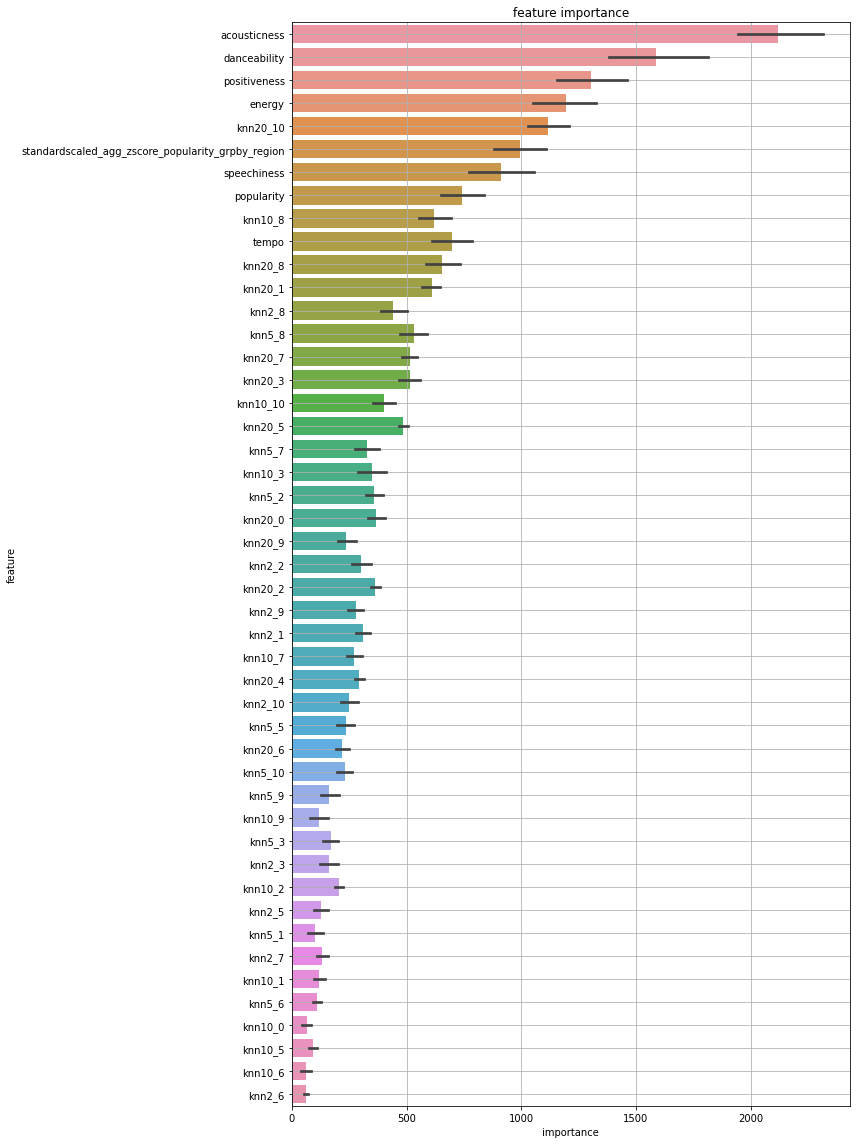

In [9]:

def training_lgb_model(df_train, target, df_test, features, N_SPLITS=N_SPLITS, features_categorical=[]):
  """
  Trainデータ
  Trainデータの予測値
  Testデータ
  分割する個数
  """
  skf = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=SEED_SKF)
  oof = np.zeros((len(df_train), N_CLASSES))
  predictions = np.zeros((len(df_test), N_CLASSES))
  df_feature_importance = pd.DataFrame()

  for fold_, (indexes_trn, indexes_val) in enumerate(skf.split(df_train.values, target.values)):
      print(f"------------------------------ fold {fold_} ------------------------------")
      
      df_trn = df_train.loc[indexes_trn].reset_index(drop=True)
      df_val = df_train.loc[indexes_val].reset_index(drop=True)
      target_trn = target.loc[indexes_trn].reset_index(drop=True)
      target_val = target.loc[indexes_val].reset_index(drop=True)
      
      lgb_train = lgb.Dataset(
          df_trn.loc[:, features],
          label=target_trn,
          categorical_feature=features_categorical
      )
      lgb_valid = lgb.Dataset(
          df_val.loc[:, features],
          label=target_val,
          categorical_feature=features_categorical
      )
      
      lgb_params["learning_rate"] = learning_rate + np.random.random() * 0.001  # おまじない
      num_round = 999999999
      model = lgb.train(
          lgb_params,
          lgb_train, 
          num_round, 
          valid_sets=[lgb_train, lgb_valid], 
          verbose_eval=300,
          early_stopping_rounds=300 if num_round >= 1e8 else None,
          fobj=None,
          #feval=lgb_metric,
      )
      
      # cv
      prediction_round = model.best_iteration+150 if num_round >= 1e8 else num_round  # おまじない
      oof[indexes_val] = model.predict(df_val[features], num_iteration=prediction_round)
      
      # feature importance
      df_fold_importance = pd.DataFrame()
      df_fold_importance["feature"] = features
      df_fold_importance["importance"] = model.feature_importance()
      df_fold_importance["fold"] = fold_
      df_feature_importance = pd.concat([df_feature_importance, df_fold_importance], axis=0)
      
      # prediction for test data
      predictions += model.predict(df_test[features], num_iteration=prediction_round) / N_SPLITS
      print()

  df_test["prediction"] = predictions.argmax(1)
  score = f1_score(target, oof.argmax(1), average="macro")
  print("CV score")
  print(f"  f1: {score:8.5f}")
  print()
  print(classification_report(target, oof.argmax(1)))

  plt.figure(figsize=(12, 16))
  sns.barplot(x="importance", y="feature", data=df_feature_importance.sort_values(by="importance", ascending=False))
  plt.title("feature importance")
  plt.grid()
  plt.tight_layout()
  plt.show()
  # 予測値, テストの値
  return oof, predictions

learning_rate = 0.01

lgb_params = {
    "objective": "multiclass",
    "num_class": N_CLASSES,
    "learning_rate": learning_rate,
    "num_leaves": 3,
    "min_data_in_leaf": 40,
    "verbosity": 0,
    "seed": 42,
}
original_cols = [
    "acousticness",
    "positiveness",
    "danceability",
    "energy",
    "speechiness",
    "tempo",
    "popularity",
    'standardscaled_agg_zscore_popularity_grpby_region'
]
layer1_cols=[
        'knn2_1', 'knn2_2', 'knn2_3', 'knn2_5', 'knn2_6',
       'knn2_7', 'knn2_8', 'knn2_9', 'knn2_10', 'knn5_1', 'knn5_2',
       'knn5_3', 'knn5_5', 'knn5_6', 'knn5_7', 'knn5_8', 'knn5_9',
       'knn5_10', 'knn10_0', 'knn10_1', 'knn10_2', 'knn10_3',
       'knn10_5', 'knn10_6', 'knn10_7', 'knn10_8', 'knn10_9', 'knn10_10',
       'knn20_0', 'knn20_1', 'knn20_2', 'knn20_3', 'knn20_4', 'knn20_5',
       'knn20_6', 'knn20_7', 'knn20_8', 'knn20_9', 'knn20_10'
       ]

features = original_cols + layer1_cols

layer2_train_pred, layer2_test_pred= training_lgb_model(
    pd.concat([df_train[original_cols], layer1_train], axis=1), 
    target, 
    pd.concat([df_test[original_cols], layer1_test], axis=1)
    ,features
)

In [11]:
df_test["prediction"] = layer2_test_pred.argmax(1)
df_submission = df_sample_sub.copy()
df_submission["genre"] = df_submission["index"].map(dict(df_test[["index", "prediction"]].values))
assert not df_submission["genre"].isna().any()
display(df_submission.head(10))

# make submission file
df_submission.to_csv("submission.csv", header=None, index=False)

,index,genre
0,4046,7
1,4047,10
2,4048,10
3,4049,8
4,4050,8
5,4051,1
6,4052,8
7,4053,4
8,4054,3
9,4055,10
